###Importing Libraries to be used

In [ ]:
import numpy as np
import pandas as pd
import collections
import librosa
import librosa.display
import scipy.io.wavfile
import scipy
from scipy import stats
import re
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
import wave
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
params = {'figure.figsize' : (12,8),'legend.fontsize': 12,'legend.handlelength': 3,'axes.titlesize' : 'large'}
plt.rcParams.update(params)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Freesound/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Freesound


###Downloading the dataset via Kaggle API

In [ ]:
os.environ['KAGGLE_USERNAME'] = "<input_username>"
os.environ['KAGGLE_KEY'] = "<input_key>"

In [ ]:
!kaggle competitions download -c freesound-audio-tagging-2019 
!unzip freesound-audio-tagging-2019.zip

100% 24.4G/24.4G [13:51<00:00, 30.9MB/s]
100% 24.4G/24.4G [13:51<00:00, 31.4MB/s]
Archive:  freesound-audio-tagging-2019.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train_curated.csv       
  inflating: train_curated.zip       
  inflating: train_noisy.csv         
  inflating: train_noisy.zip         


In [ ]:
%cd /content/gdrive/MyDrive/Freesound/train_curated/
!unzip train_curated.zip
%cd /content/gdrive/MyDrive/Freesound/train_noisy/
!unzip train_noisy.zip
%cd /content/gdrive/MyDrive/Freesound/test/
!unzip test.zip

###Reading the dataset

In [ ]:
#Curated data
trainframeT = pd.read_csv('/content/gdrive/MyDrive/Freesound/train_curated.csv')
#Noisy data
trainframeN = pd.read_csv('/content/gdrive/MyDrive/Freesound/train_noisy.csv')

In [ ]:
trainframeT.shape

(4970, 2)

In [ ]:
trainframeN.shape

(19815, 2)

In [ ]:
trainframeT.head(5)

fname           labels
0  0006ae4e.wav             Bark
1  0019ef41.wav         Raindrop
2  001ec0ad.wav  Finger_snapping
3  0026c7cb.wav              Run
4  0026f116.wav  Finger_snapping

In [ ]:
trainframeN.head(5)

fname                                          labels
0  00097e21.wav                    Bathtub_(filling_or_washing)
1  000b6cfb.wav                                      Motorcycle
2  00116cd2.wav              Marimba_and_xylophone,Glockenspiel
3  00127d14.wav  Water_tap_and_faucet,Sink_(filling_or_washing)
4  0019adae.wav                                        Raindrop

###Visualizing & Playing the audio file

####Curated Audio File

In [ ]:
IPython.display.Audio("/content/gdrive/MyDrive/Freesound/train_curated/0164cba5.wav")

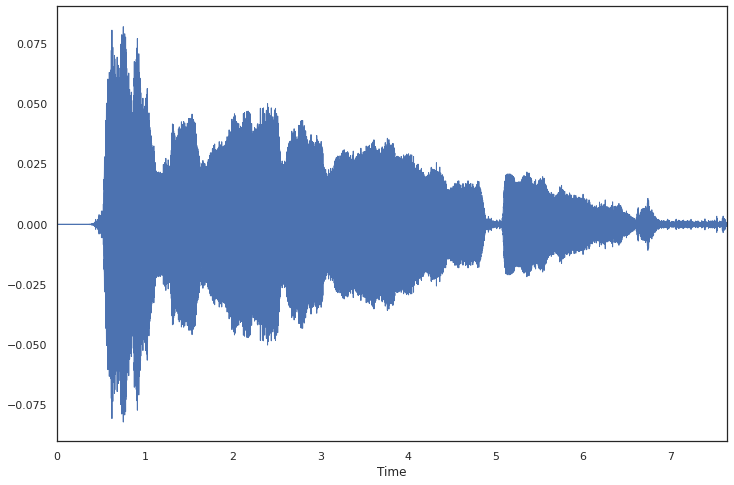

In [ ]:
x,sr=librosa.load('/content/gdrive/MyDrive/Freesound/train_curated/0164cba5.wav')
librosa.display.waveplot(x,sr=sr)

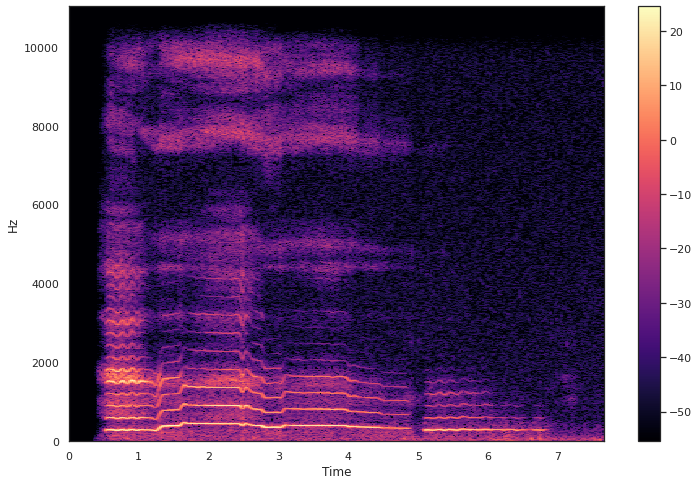

In [ ]:
Xdb = librosa.amplitude_to_db(abs(librosa.stft(x)))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

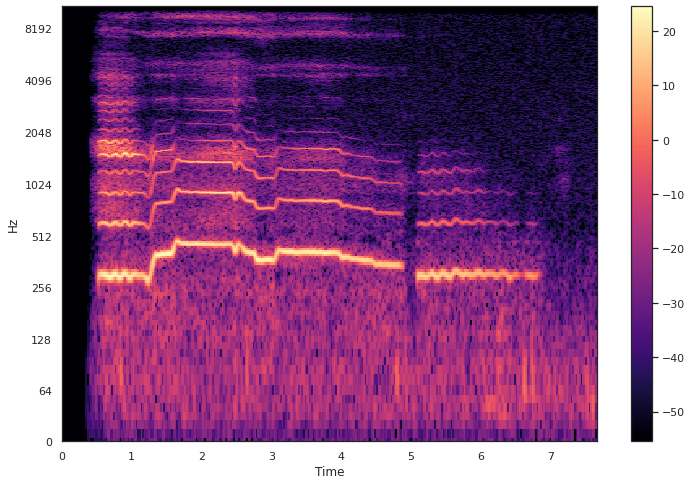

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

####Noisy Audio File

In [ ]:
IPython.display.Audio("/content/gdrive/MyDrive/Freesound/train_noisy/001f3501.wav")

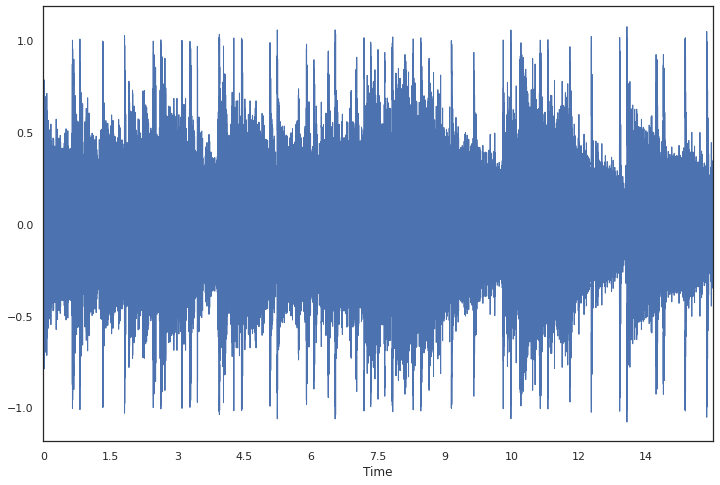

In [ ]:
x,sr=librosa.load('/content/gdrive/MyDrive/Freesound/train_noisy/001f3501.wav')
librosa.display.waveplot(x,sr=sr)

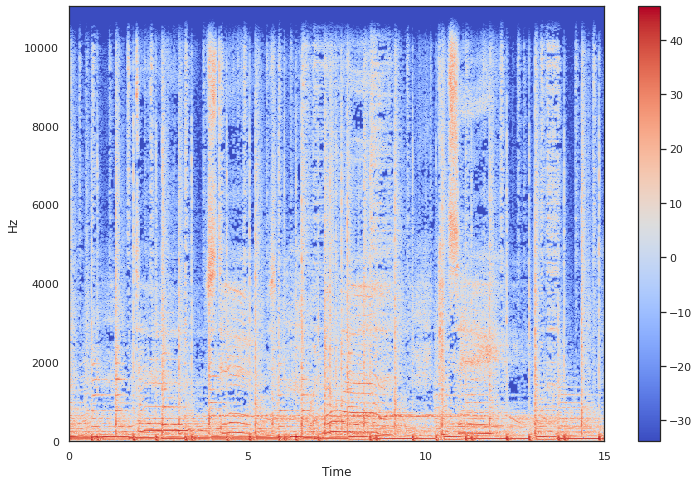

In [ ]:
Xdb = librosa.amplitude_to_db(abs(librosa.stft(x)))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

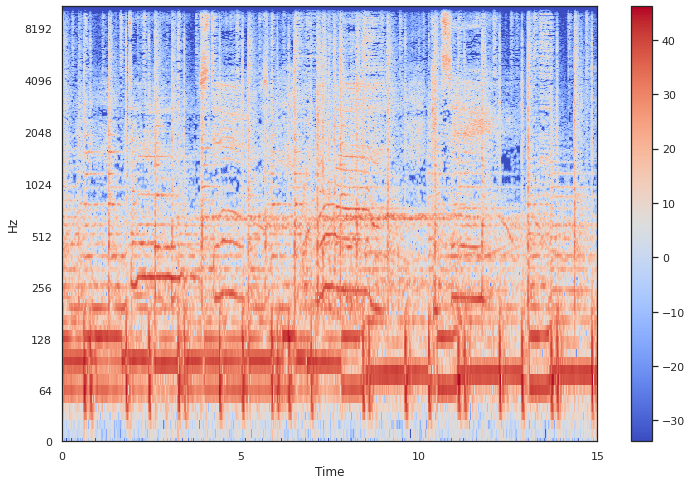

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

###Inference -> 

1. There are 4970 curated and 19815 noisy audio files.
2. Every audio file is identified via an unique "fname" filename.
3. Audio files have varying length of clips.


##Performing EDA on "Labels" which is the target variable

####1. Count of Audio clip for every unique Label in order to see whether the dataset is balanced or not

#####Curated Trainframe

In [ ]:
c = sorted({label: sum(label in row for row in [r.split(',') for r in trainframeT['labels']]) for label in set(label for row in [r.split(',') for r in trainframeT['labels']] for label in row)}.items(), 
            key=lambda x: x[1])

In [ ]:
print("Count of labels in curated trainframe = ", len(c))

Count of labels in curated trainframe =  80


In [ ]:
pd.DataFrame(c, columns=["Label", "Count"])['Count'].describe()

count    80.000000
mean     71.900000
std       7.460614
min      47.000000
25%      75.000000
50%      75.000000
75%      75.000000
max      75.000000
Name: Count, dtype: float64

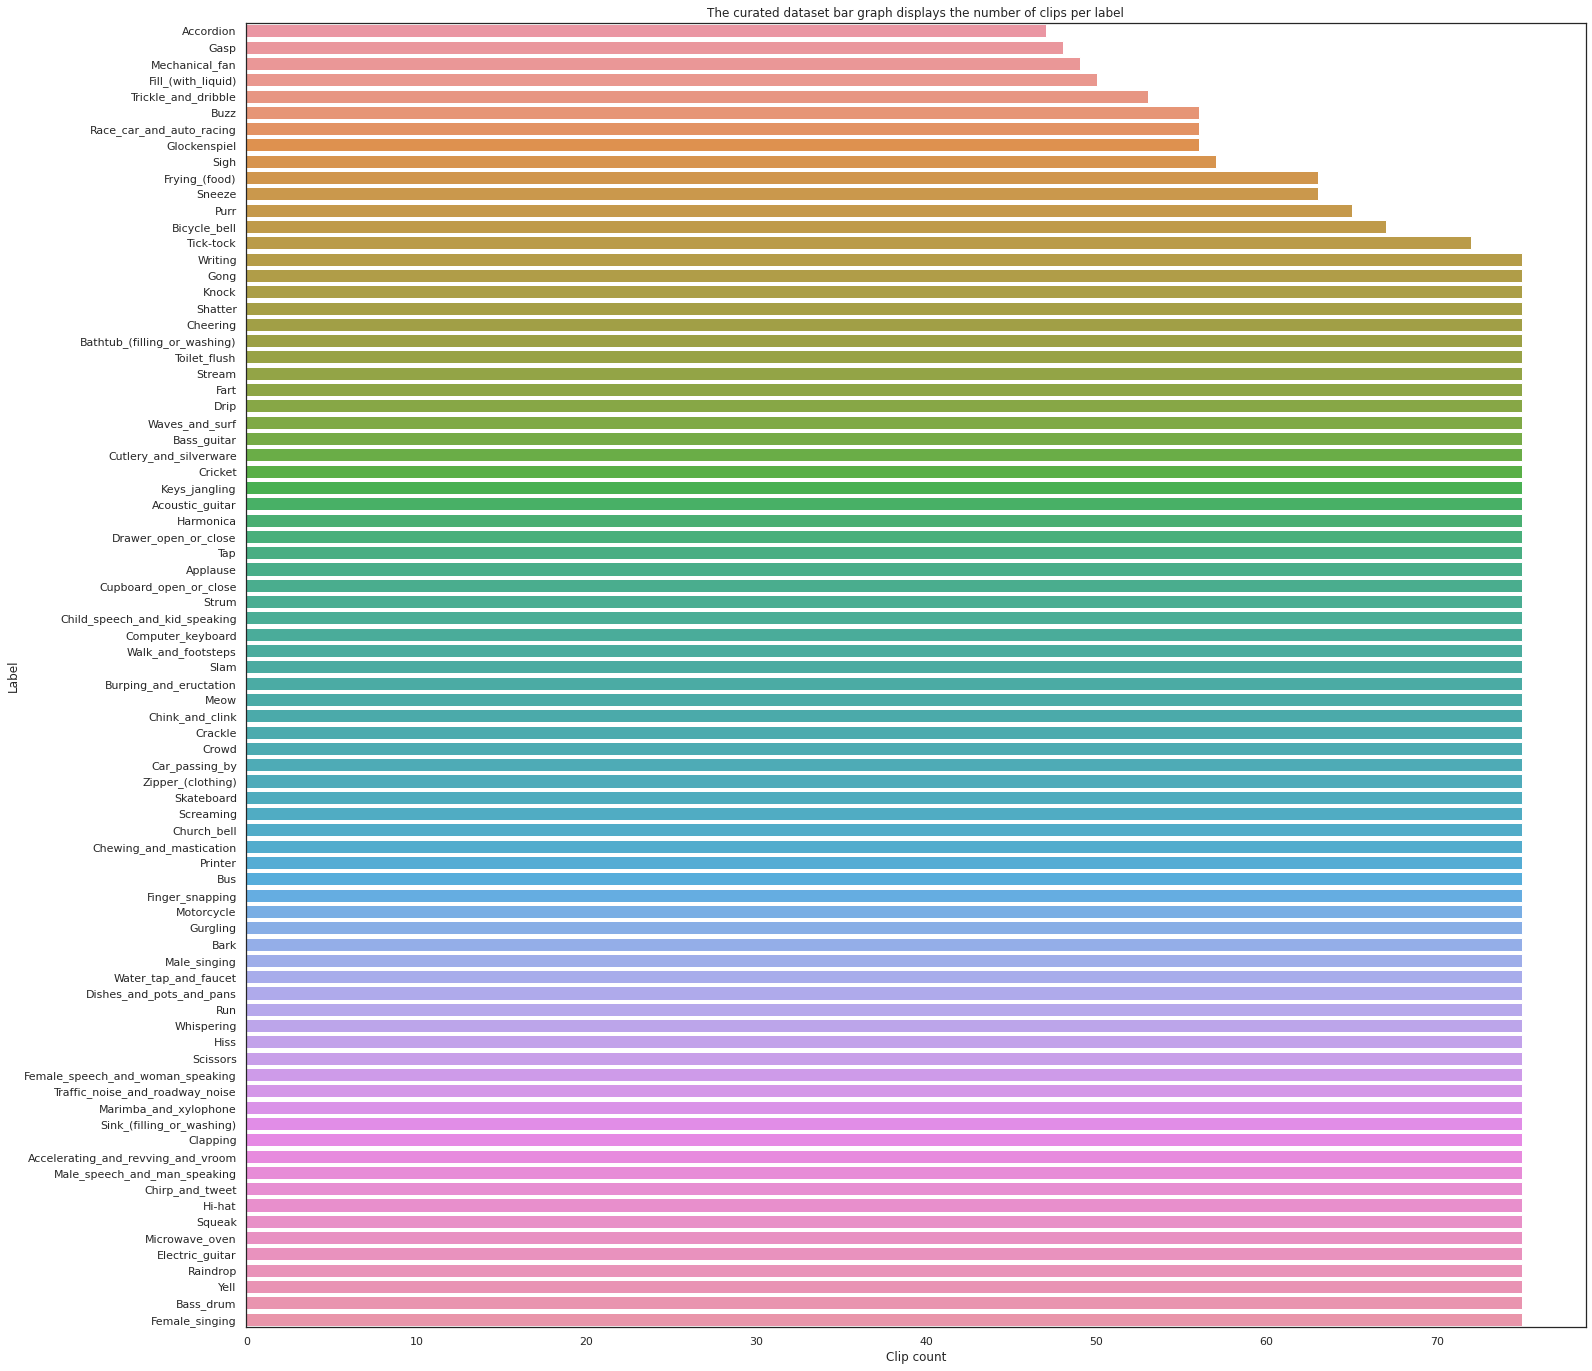

In [ ]:
sns.barplot(x='Count', y='Label', data=pd.DataFrame(c, columns=["Label", "Count"]))
plt.title('The curated dataset bar graph displays the number of clips per label')
plt.xlabel('Clip count')
plt.show()

#####Noisy Trainframe

In [ ]:
c = sorted({label: sum(label in row for row in [r.split(',') for r in trainframeN['labels']]) 
            for label in set(label for row in [r.split(',') for r in trainframeN['labels']] for label in row)}.items(), 
            key=lambda x: x[1])

In [ ]:
print("Count of labels in Noisy trainframe = ", len(c))

Count of labels in Noisy trainframe =  80


In [ ]:
pd.DataFrame(c, columns=["Label", "Count"])['Count'].describe()

count     80.0
mean     300.0
std        0.0
min      300.0
25%      300.0
50%      300.0
75%      300.0
max      300.0
Name: Count, dtype: float64

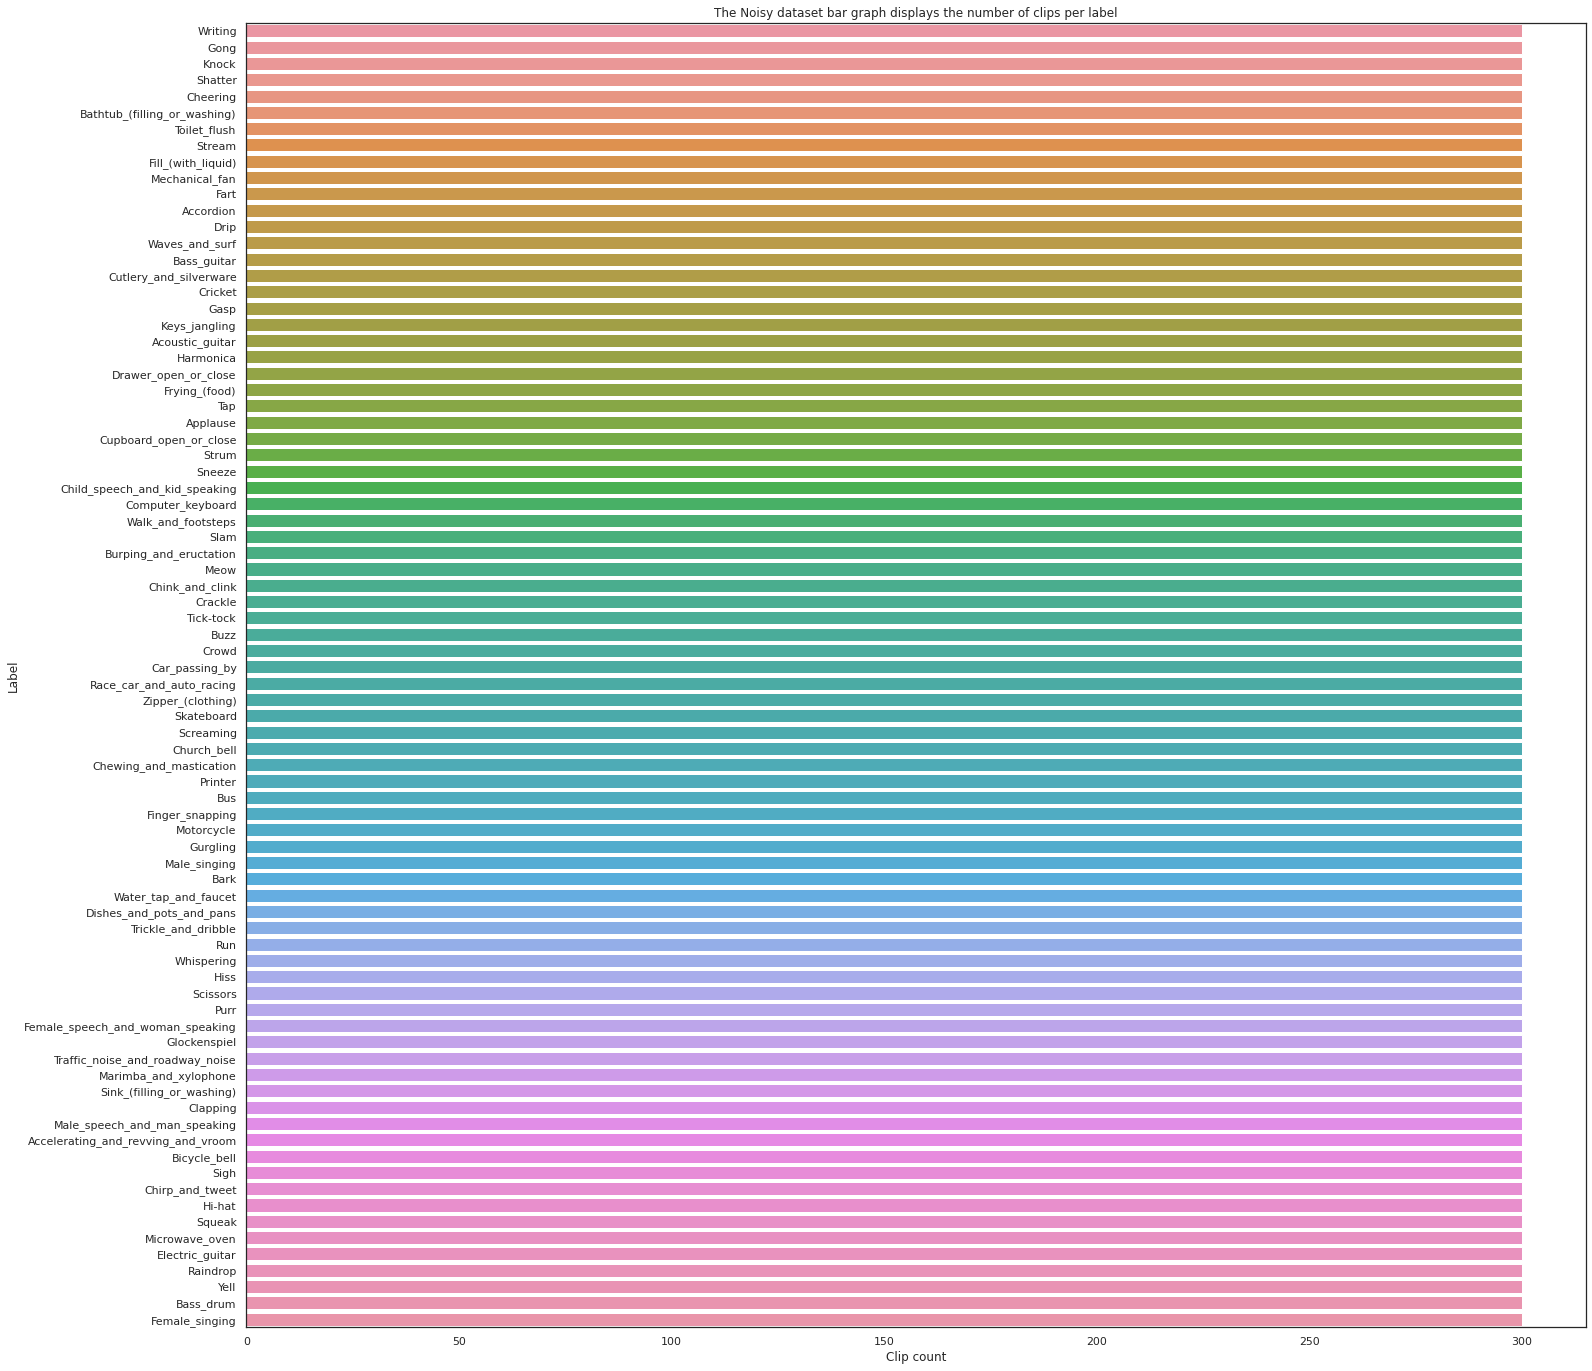

In [ ]:
sns.barplot(x='Count', y='Label', data=pd.DataFrame(c, columns=["Label", "Count"]))
plt.title('The Noisy dataset bar graph displays the number of clips per label')
plt.xlabel('Clip count')
plt.show()

###Inference -> 

The trainframe of both the curated and the noisy **dataset is balanced** as the count of clips for each label is almost equal in curated set and exactly equal in noisy set which can be seen in the above barplots.

####2. Count of labels for each audio clip.

#####Curated Trainframe set

In [ ]:
nlc = sorted(dict(collections.Counter(len(row) for row in [label.split(',') for label in list(trainframeT['labels'])])).items(),
             key=lambda x: x[1], reverse=True)

In [ ]:
tfc = pd.DataFrame(nlc, columns=["CountL", "Count"])
tfc['Percent'] = 100*tfc['Count']/tfc['Count'].sum()
tfc

CountL  Count    Percent
0       1   4269  85.895372
1       2    627  12.615694
2       3     69   1.388330
3       4      4   0.080483
4       6      1   0.020121

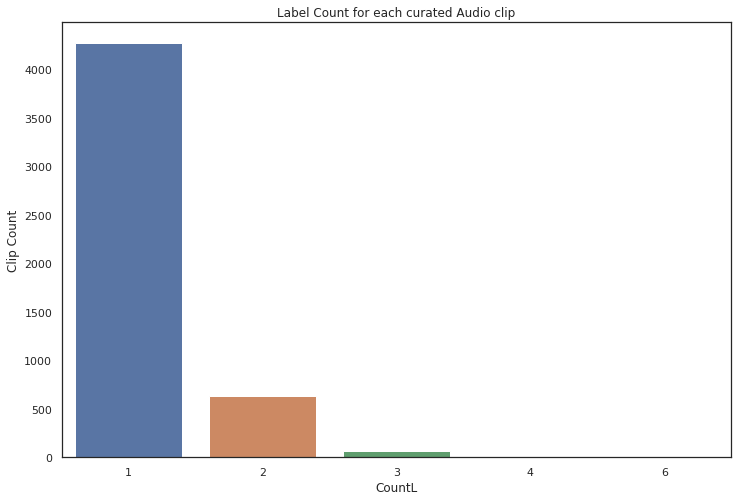

In [ ]:
sns.barplot(x='CountL', y='Count', data=tfc)
plt.title('Label Count for each curated Audio clip')
plt.ylabel('Clip Count')
plt.show()

#####Noisy Trainframe set

In [ ]:
nln = sorted(dict(collections.Counter(len(row) for row in [label.split(',') for label in list(trainframeN['labels'])])).items(), 
             key=lambda x: x[1], reverse=True)

In [ ]:
tfn = pd.DataFrame(nlc, columns=["CountL", "Count"])
tfn['Percent'] = 100*tfc['Count']/tfc['Count'].sum()
tfn

CountL  Count    Percent
0       1  16566  85.895372
1       2   2558  12.615694
2       3    504   1.388330
3       4    141   0.080483
4       5     38   0.020121
5       6      4        NaN
6       7      4        NaN

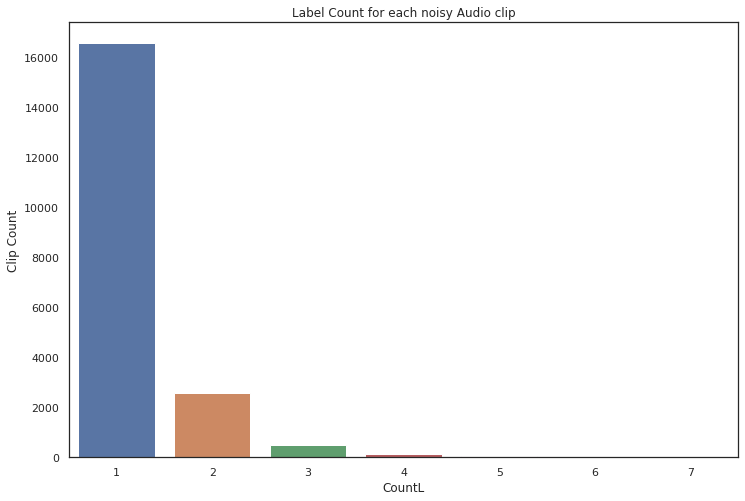

In [ ]:
sns.barplot(x='CountL', y='Count', data=tfn)
plt.title('Label Count for each noisy Audio clip')
plt.ylabel('Clip Count')
plt.show()

####Inference -> 

84% of the curated trainframe has only a single label, 13% has 2 labels and **VERY** few (almost 2%) have 3 labels. This Variation of the count of labels is found to be almost same in the noisy trainframe.

####3. Audio length of each clip.

#####Curated trainframe set

In [ ]:
def getsec(fname):
  """ 
      Description -> It takes the filename as the input and returns the length of that audio file in seconds.
  """
  return wave.open(r'/content/gdrive/MyDrive/Freesound/train_curated/'+fname).getnframes()/wave.open(r'/content/gdrive/MyDrive/Freesound/train_curated/'+fname).getframerate()

In [ ]:
trainframeT['length'] = trainframeT['fname'].apply(getsec)

In [ ]:
trainframeT['length'].describe()

count    4970.000000
mean        7.647674
std         7.696291
min         0.300000
25%         1.612205
50%         4.675918
75%        11.146372
max        57.571179
Name: length, dtype: float64

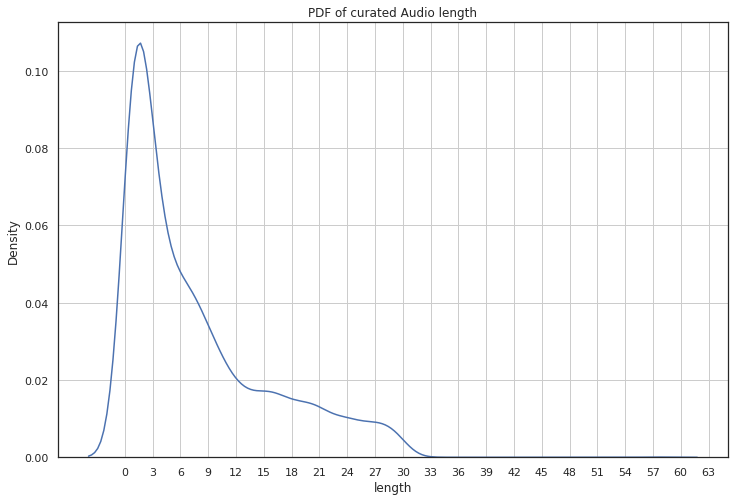

In [ ]:
sns.kdeplot(trainframeT['length'])
plt.title('PDF of curated Audio length')
plt.xticks(np.arange(0, 64, 3))
plt.grid()
plt.show()

In [ ]:
srl = np.random.choice(np.array(list(set(label for row in trainframeT['labels'].values for label in row.split(',')))), size=6, replace=False)
dsrl = trainframeT[trainframeT['labels'].str.contains('|'.join(srl))].assign(labels=trainframeT['labels'].str.extract('({})'.format('|'.join(srl)))).reset_index(drop=True)

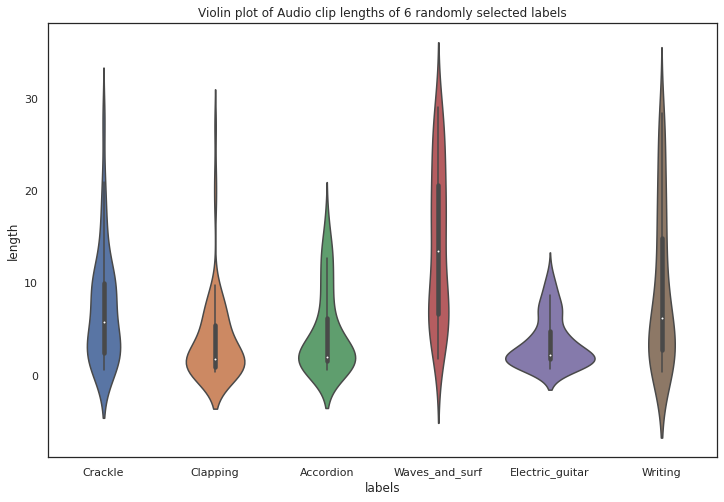

In [ ]:
sns.violinplot(x='labels', y='length', data=dsrl)
plt.title("Violin plot of Audio clip lengths of 6 randomly selected labels")
plt.show()

#####Noisy trainframe set

In [ ]:
def getsecn(fname):
  """ 
      Description -> It takes the filename as the input and returns the length of that audio file in seconds.
  """
  return wave.open(r'/content/gdrive/MyDrive/Freesound/train_noisy/'+fname).getnframes()/wave.open(r'/content/gdrive/MyDrive/Freesound/train_noisy/'+fname).getframerate()

In [ ]:
trainframeN['length'] = trainframeN['fname'].apply(getsecn)

In [ ]:
trainframeN['length'].describe()

count    19815.000000
mean        14.591555
std          1.623519
min          1.044898
25%         15.000000
50%         15.000000
75%         15.000000
max         15.998549
Name: length, dtype: float64

In [ ]:
import joblib
trainframeT=joblib.load('/content/gdrive/MyDrive/Freesound/trainframeT.joblib')
trainframeN=joblib.load('/content/gdrive/MyDrive/Freesound/trainframeN.joblib')

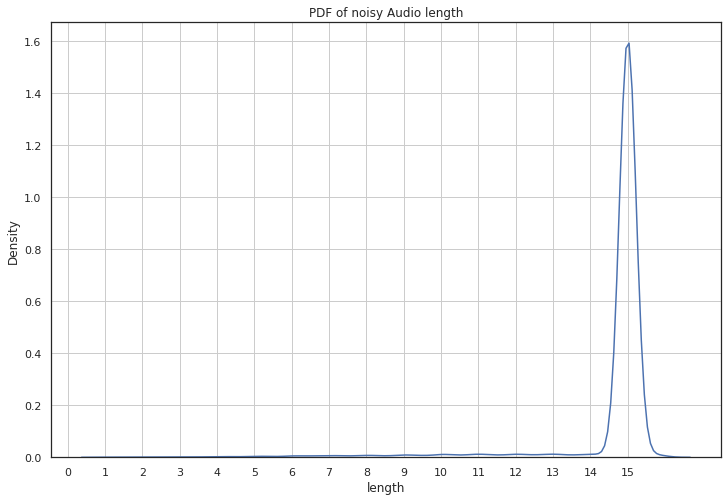

In [ ]:
sns.kdeplot(trainframeN['length'])
plt.title('PDF of noisy Audio length')
plt.xticks(np.arange(0, 16, 1))
plt.grid()
plt.show()

In [ ]:
print("15 seconds length clip percentage = ", trainframeN[trainframeN['length'] == 15].shape[0]*100/trainframeN.shape[0], "%")

15 seconds length clip percentage =  89.66944234166036 %


In [ ]:
snl = np.random.choice(np.array(list(set(label for row in trainframeT['labels'].values for label in row.split(',')))), size=6, replace=False)
dsnl = trainframeN[trainframeN['labels'].str.contains('|'.join(snl))].assign(labels=trainframeN['labels'].str.extract('({})'.format('|'.join(snl)))).reset_index(drop=True)

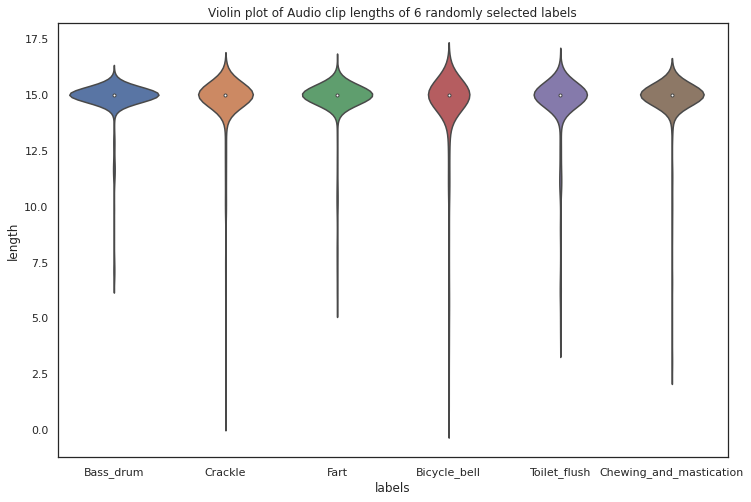

In [ ]:
sns.violinplot(x='labels', y='length', data=dsnl)
plt.title("Violin plot of Audio clip lengths of 6 randomly selected labels")
plt.show()

####Inference -> 

1. The length/duration of curated audio clips varies between 0.3 and 30 seconds, with a mean length of 4.5 seconds. Some audio clips have very little variation in length, while others have a significant difference in length.

2. The noisy clips have comparable variances in audio length. This is consistent with the noisy dataset's 90% of audio clips being exactly 15 seconds long, which leads to a similar variance in the length of the different labels.

3. The varying length of audio clips in the curated dataset allows for a more diverse representation of audio patterns, making it a potentially richer source for analysis and modeling

####4. Amplitude of clips

In [ ]:
def ampc(dir):
  """
  Description -> It takes the train directory as input and outputs each peak and average amplitude
                 of all the audio files present in that directory.
  """
  files = os.listdir(dir)
  peak = np.array([np.max(np.abs(scipy.io.wavfile.read(dir + file)[1])) for file in files]).sort()
  avg = np.array([np.mean(np.abs(scipy.io.wavfile.read(dir + file)[1])) for file in files]).sort()  
  return (peak,avg)

#####Curated trainframe set

In [ ]:
peak,avg = ampc(r'/content/gdrive/MyDrive/Freesound/train_curated/')

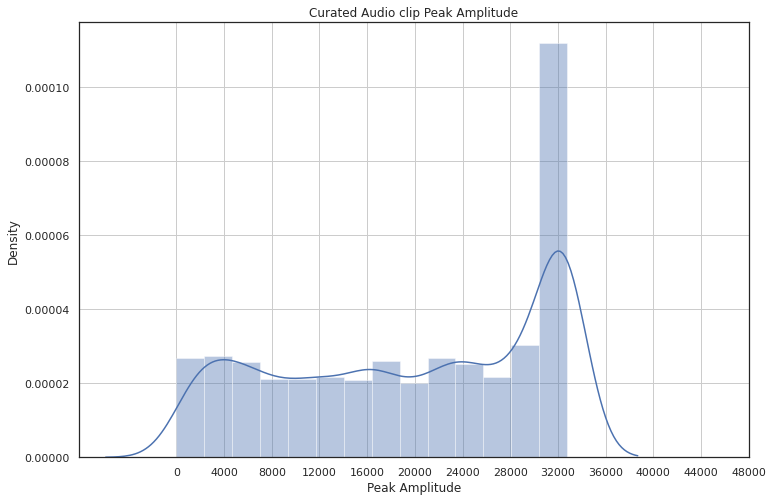

In [ ]:
sns.distplot(peak)
plt.title('Curated Audio clip Peak Amplitude')
plt.xticks(np.arange(0,50000,4000))
plt.xlabel('Peak Amplitude')
plt.grid()
plt.show()

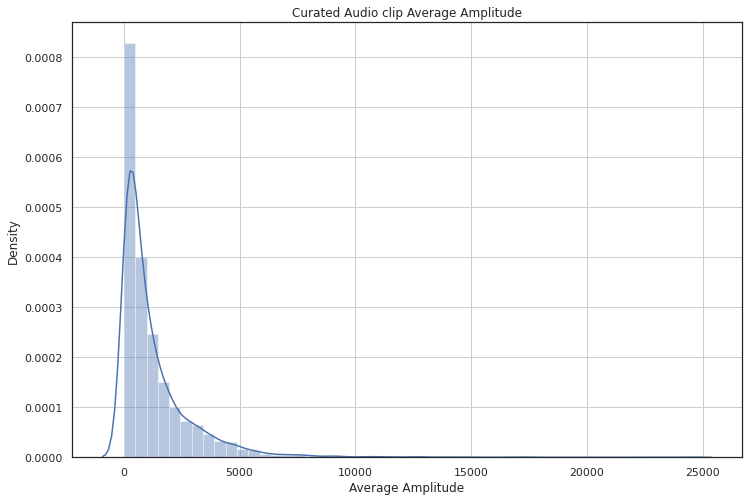

In [ ]:
sns.distplot(avg)
plt.title('Curated Audio clip Average Amplitude')
plt.xlabel('Average Amplitude')
plt.grid()
plt.show()

#####Noisy trainframe set

In [ ]:
peakn,avgn = ampc(r'/content/gdrive/MyDrive/Freesound/train_noisy/')

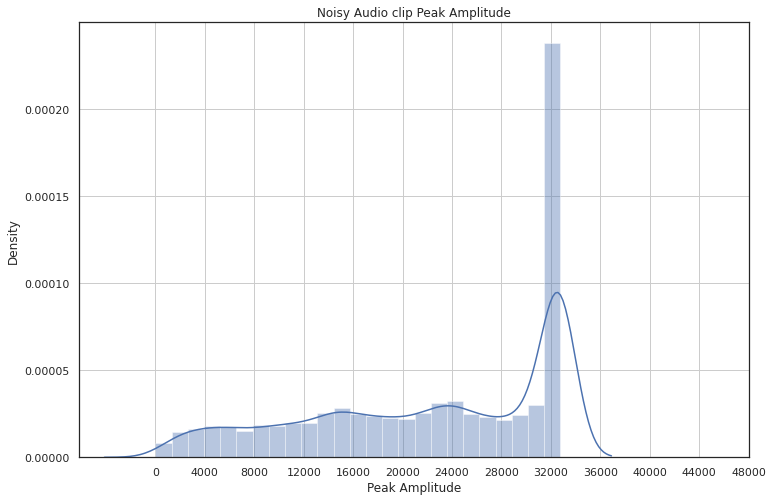

In [ ]:
sns.distplot(peakn)
plt.title('Noisy Audio clip Peak Amplitude')
plt.xticks(np.arange(0,50000,4000))
plt.xlabel('Peak Amplitude')
plt.grid()
plt.show()

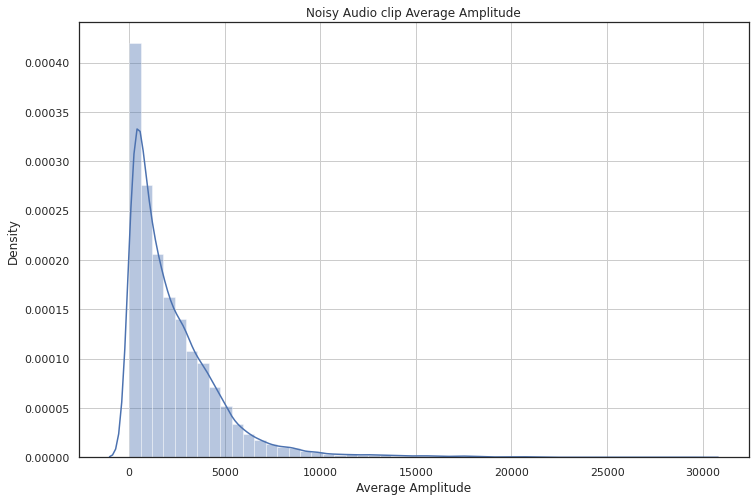

In [ ]:
sns.distplot(avgn)
plt.title('Noisy Audio clip Average Amplitude')
plt.xlabel('Average Amplitude')
plt.grid()
plt.show()

###Inference -> 

1. The average peak amplitude of the selected and noisy clips is almost 32000.
2. Both types of clips' average amplitudes follow a distribution that resembles the Power Law distribution.

###5. Extraction of Frequency using Fast Fourier transform

In [ ]:
def freq(dir):
    """
    Description -> It takes the file directory as input and applies fast fourier transform FFT in order to extract the peak frequency of 
                   the audio files contained in the directory.
    """
    files = os.listdir(dir)
    peak_frequencies_curated = np.zeros(len(files))        
    peak_frequencies_curated = np.array([abs(np.fft.fftfreq(len(np.fft.fft(scipy.io.wavfile.read(dir + file)[1])))[np.argmax(np.abs(np.fft.fft(scipy.io.wavfile.read(dir + file)[1])))]) * scipy.io.wavfile.read(dir + file)[0] for file in files])        
    return np.sort(peak_frequencies_curated)

#####Curated trainframe set

In [ ]:
peakfreqc = freq(r'/content/gdrive/MyDrive/Freesound/train_curated/')

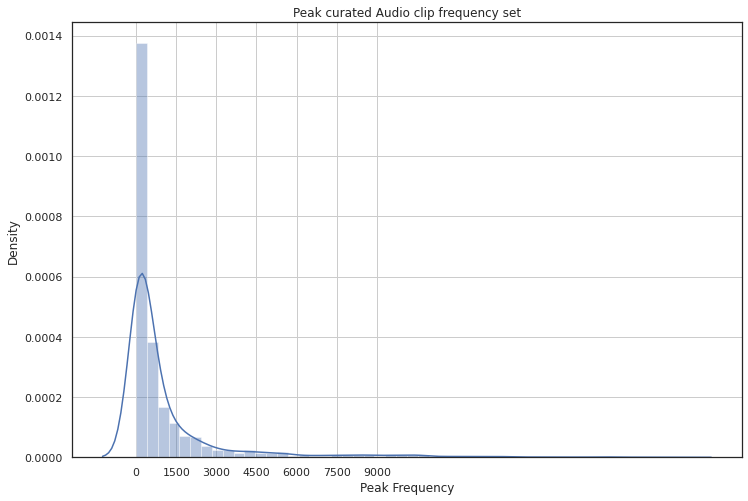

In [ ]:
plt.title('Peak curated Audio clip frequency set')
sns.distplot(peakfreqc)
plt.grid()
plt.xticks(np.arange(0, 10000, 1500))
plt.xlabel('Peak Frequency')
plt.show()

#####Noisy trainframe set

In [ ]:
peakfreqn = freq(r'/content/gdrive/MyDrive/Freesound/train_noisy/')

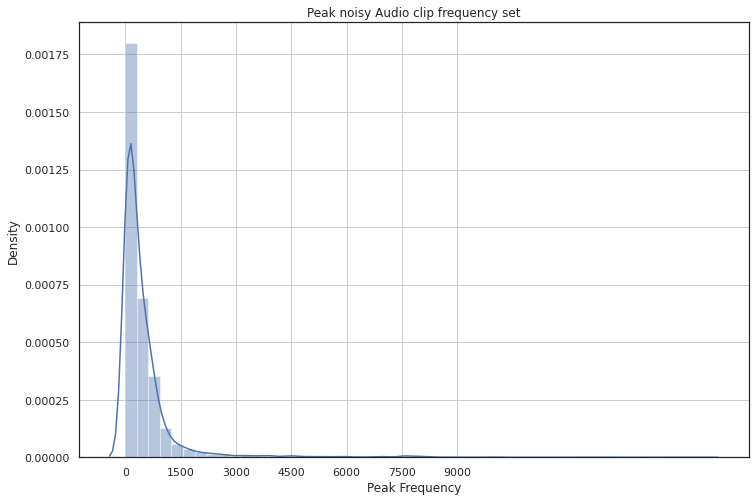

In [ ]:
plt.title('Peak noisy Audio clip frequency set')
sns.distplot(peakfreqn)
plt.grid()
plt.xticks(np.arange(0, 10000, 1500))
plt.xlabel('Peak Frequency')
plt.show()

###Inference -> 

The peak & average frequency follows a distribution which resembles the power law distribution.